# Age of death prediction using linear regression
Using the WHO life expectancy dataset: https://www.kaggle.com/kumarajarshi/life-expectancy-who/data#

In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import pickle

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/Federico-abss/pytorch_gans/master/datasets/life_expectancy_data.csv"
DATA_FILENAME = "life_expectancy_data.csv"
input_size=5
output_size=1

In [3]:
# Download the data
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)

dataframe.describe()

Using downloaded and verified file: .\life_expectancy_data.csv


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Cleaning the data
Some cell names have trailing spaces or are composed of two separate names, I am gonna fix that and impose a more consistent naming scheme

In [4]:
# Renaming some column names as they contain trailing spaces.
dataframe.rename(columns={" BMI ":"BMI","Life expectancy ":"Life_Expectancy","Adult Mortality":"Adult_Mortality",
                   "infant deaths":"Infant_Deaths","percentage expenditure":"Percentage_Exp","Hepatitis B":"HepatitisB",
                  "Measles ":"Measles"," BMI ":"BMI","under-five deaths ":"Under_Five_Deaths","Diphtheria ":"Diphtheria",
                  " HIV/AIDS":"HIV/AIDS"," thinness  1-19 years":"thinness_1to19_years"," thinness 5-9 years":"thinness_5to9_years","Income composition of resources":"Income_Comp_Of_Resources",
                   "Total expenditure":"Tot_Exp"},inplace=True)
dataframe.head()

,Country,Year,Status,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Exp,HepatitisB,Measles,...,Polio,Tot_Exp,Diphtheria,HIV/AIDS,GDP,Population,thinness_1to19_years,thinness_5to9_years,Income_Comp_Of_Resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
# Verifying whether data for each variable is according to its dataype or not.
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   2938 non-null   object 
 1   Year                      2938 non-null   int64  
 2   Status                    2938 non-null   object 
 3   Life_Expectancy           2928 non-null   float64
 4   Adult_Mortality           2928 non-null   float64
 5   Infant_Deaths             2938 non-null   int64  
 6   Alcohol                   2744 non-null   float64
 7   Percentage_Exp            2938 non-null   float64
 8   HepatitisB                2385 non-null   float64
 9   Measles                   2938 non-null   int64  
 10  BMI                       2904 non-null   float64
 11  Under_Five_Deaths         2938 non-null   int64  
 12  Polio                     2919 non-null   float64
 13  Tot_Exp                   2712 non-null   float64
 14  Diphther

In [6]:
# Identify percentage of null values in each column.
dataframe.isnull().sum()*100/dataframe.isnull().count()

Country                      0.000000
Year                         0.000000
Status                       0.000000
Life_Expectancy              0.340368
Adult_Mortality              0.340368
Infant_Deaths                0.000000
Alcohol                      6.603131
Percentage_Exp               0.000000
HepatitisB                  18.822328
Measles                      0.000000
BMI                          1.157250
Under_Five_Deaths            0.000000
Polio                        0.646698
Tot_Exp                      7.692308
Diphtheria                   0.646698
HIV/AIDS                     0.000000
GDP                         15.248468
Population                  22.191967
thinness_1to19_years         1.157250
thinness_5to9_years          1.157250
Income_Comp_Of_Resources     5.684139
Schooling                    5.547992
dtype: float64

In [7]:
# save the countries in a list
country_list = dataframe.Country.unique()

# list containing incomplete columns
fill_list = ['Life_Expectancy','Adult_Mortality','Alcohol','HepatitisB','BMI','Polio','Tot_Exp','Diphtheria','GDP','Population','thinness_1to19_years','thinness_5to9_years','Income_Comp_Of_Resources','Schooling']

In [8]:
# Treat null values using interpolation.
for country in country_list:
    dataframe.loc[dataframe['Country'] == country,fill_list] = dataframe.loc[dataframe['Country'] == country,fill_list].interpolate()
    
# Drop remaining null values after interpolation.
dataframe.dropna(inplace=True)

In [9]:
# Verifying null-values after applying above methods.
dataframe.isnull().sum()

Country                     0
Year                        0
Status                      0
Life_Expectancy             0
Adult_Mortality             0
Infant_Deaths               0
Alcohol                     0
Percentage_Exp              0
HepatitisB                  0
Measles                     0
BMI                         0
Under_Five_Deaths           0
Polio                       0
Tot_Exp                     0
Diphtheria                  0
HIV/AIDS                    0
GDP                         0
Population                  0
thinness_1to19_years        0
thinness_5to9_years         0
Income_Comp_Of_Resources    0
Schooling                   0
dtype: int64

## Data analysis
We are gonna look for relevant correlations to decide which columns we will use to train our model<br>
Let's start with some general statistics about our data

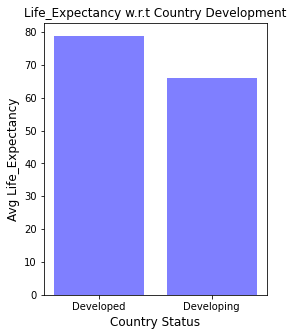

In [10]:
# Life_Expectancy w.r.t Year using bar plot.
plt.figure(figsize=(4,5))
plt.bar(dataframe.groupby('Status')['Status'].count().index,dataframe.groupby('Status')['Life_Expectancy'].mean(),color='blue',alpha=0.50)
plt.xlabel("Country Status",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Country Development")
plt.show()

In [11]:
round(dataframe[['Status','Life_Expectancy']].groupby(['Status']).mean(),2)

,Life_Expectancy
Status,
Developed,78.83
Developing,66.16


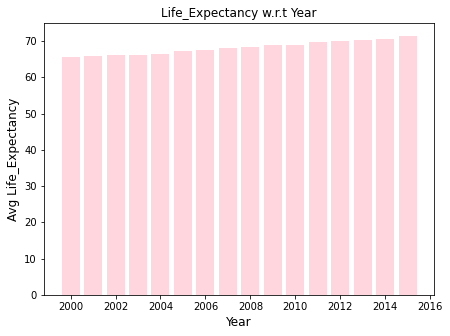

In [12]:
# Life_Expectancy w.r.t Year using bar plot.
plt.figure(figsize=(7,5))
plt.bar(dataframe.groupby('Year')['Year'].count().index,dataframe.groupby('Year')['Life_Expectancy'].mean(),color='pink',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Year")
plt.show()

So there is a definite difference between developed countries and the rest, but at least the life expectancy improves every year.
Now let's try to figure out wich features affect life expectancy the most.

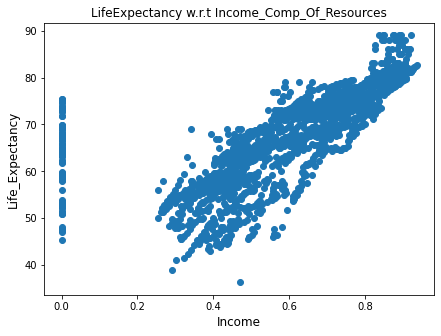

In [13]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t Income_Comp_Of_Resources")
plt.xlabel("Income",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Income_Comp_Of_Resources"], dataframe["Life_Expectancy"])

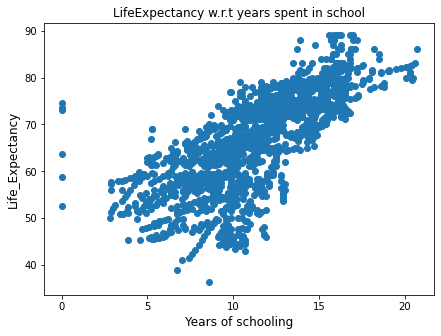

In [14]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t years spent in school")
plt.xlabel("Years of schooling",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Schooling"], dataframe["Life_Expectancy"])

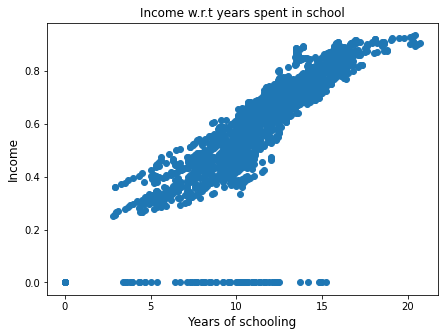

In [15]:
plt.figure(figsize=(7,5))
plt.title("Income w.r.t years spent in school")
plt.xlabel("Years of schooling",fontsize=12)
plt.ylabel("Income",fontsize=12)
plt.scatter(dataframe["Schooling"], dataframe["Income_Comp_Of_Resources"])

We can infer that schooling and income composition are positively correlated between themselves and with life expectancy

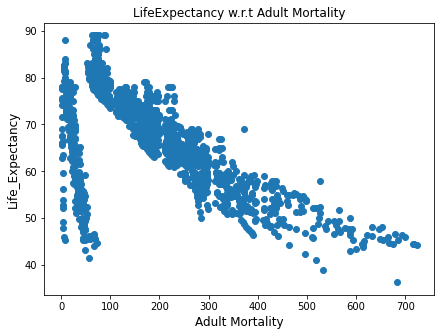

In [16]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t Adult Mortality")
plt.xlabel("Adult Mortality",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["Adult_Mortality"], dataframe["Life_Expectancy"])

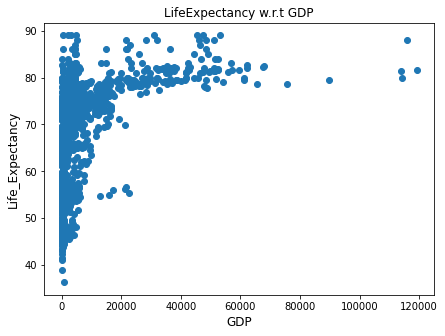

In [17]:
plt.figure(figsize=(7,5))
plt.title("LifeExpectancy w.r.t GDP")
plt.xlabel("GDP",fontsize=12)
plt.ylabel("Life_Expectancy",fontsize=12)
plt.scatter(dataframe["GDP"], dataframe["Life_Expectancy"])

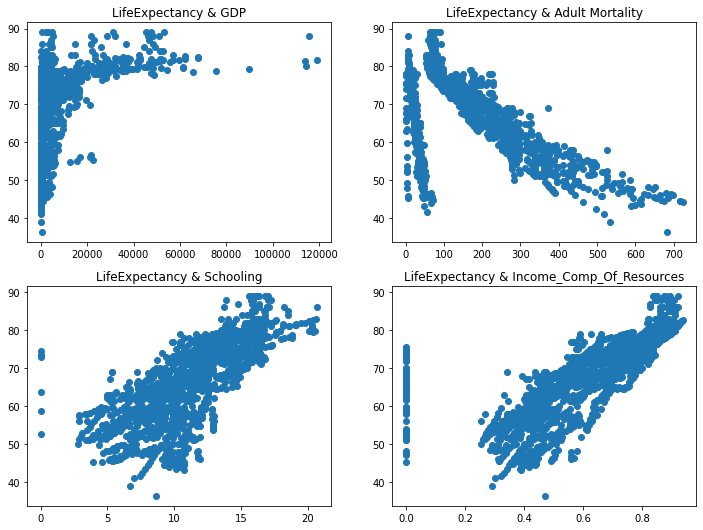

In [18]:
plt.figure(figsize=(12, 38))

plt.subplot(8,2,1)
plt.title("LifeExpectancy & GDP")
plt.scatter(dataframe["GDP"], dataframe["Life_Expectancy"])

plt.subplot(8,2,2)
plt.title("LifeExpectancy & Adult Mortality")
plt.scatter(dataframe["Adult_Mortality"], dataframe["Life_Expectancy"])

plt.subplot(8,2,3)
plt.title("LifeExpectancy & Schooling")
plt.scatter(dataframe["Schooling"], dataframe["Life_Expectancy"])

plt.subplot(8,2,4)
plt.title("LifeExpectancy & Income_Comp_Of_Resources")
plt.scatter(dataframe["Income_Comp_Of_Resources"], dataframe["Life_Expectancy"])

The four features shown above plus the status of the country will be used for building the machine learning model

## Data loaders
Now I will prepare the designated column into the data that will be used in the ml model

In [19]:
# label the designated data
num_rows = dataframe.index.size
categorical_cols = ['Status']
TARGET_COLUMN = ['Life_Expectancy']
inputs = ['Status', 'GDP', 'Adult_Mortality', 'Schooling', 'Income_Comp_Of_Resources']
dataframe[inputs].head()

,Status,GDP,Adult_Mortality,Schooling,Income_Comp_Of_Resources
0,Developing,584.259210,263.0,10.1,0.479
1,Developing,612.696514,271.0,10.0,0.476
2,Developing,631.744976,268.0,9.9,0.470
3,Developing,669.959000,272.0,9.8,0.463
4,Developing,63.537231,275.0,9.5,0.454


In [20]:
# Convert from Pandas dataframe to numpy arrays
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[inputs].to_numpy()
    targets_array = dataframe1[TARGET_COLUMN].to_numpy()
    return inputs_array, targets_array

In [21]:
inputs, targets = dataframe_to_arrays(dataframe)
inputs, targets

(array([[1.00000000e+00, 5.84259210e+02, 2.63000000e+02, 1.01000000e+01,
         4.79000000e-01],
        [1.00000000e+00, 6.12696514e+02, 2.71000000e+02, 1.00000000e+01,
         4.76000000e-01],
        [1.00000000e+00, 6.31744976e+02, 2.68000000e+02, 9.90000000e+00,
         4.70000000e-01],
        ...,
        [1.00000000e+00, 5.73483400e+01, 7.30000000e+01, 1.00000000e+01,
         4.27000000e-01],
        [1.00000000e+00, 5.48587312e+02, 6.86000000e+02, 9.80000000e+00,
         4.27000000e-01],
        [1.00000000e+00, 5.47358879e+02, 6.65000000e+02, 9.80000000e+00,
         4.34000000e-01]]),
 array([[65. ],
        [59.9],
        [59.9],
        ...,
        [44.8],
        [45.3],
        [46. ]]))

In [22]:
inputs.shape, targets.shape

((1987, 5), (1987, 1))

In [23]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))

val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size=2**9
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

## Model

In [24]:
class LifeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.l1_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 50th epoch
        if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

## Training

In [25]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[0.0000e+00, 2.3196e+04, 8.5000e+01, 1.6200e+01, 8.1800e-01],
        [0.0000e+00, 2.2822e+04, 5.9000e+01, 1.4800e+01, 8.2600e-01],
        [1.0000e+00, 1.7455e+04, 1.3800e+02, 1.6400e+01, 8.3800e-01],
        ...,
        [1.0000e+00, 2.1452e+04, 3.4400e+02, 9.2000e+00, 5.8000e-01],
        [0.0000e+00, 1.6672e+04, 6.6000e+01, 1.4800e+01, 8.0900e-01],
        [1.0000e+00, 5.2822e+03, 6.8000e+01, 1.5900e+01, 9.0300e-01]])
targets: tensor([[82.0000],
        [87.0000],
        [76.1000],
        [51.0000],
        [58.8000],
        [45.3000],
        [79.3000],
        [67.8000],
        [57.5000],
        [68.0000],
        [73.8000],
        [74.8000],
        [61.3000],
        [58.6000],
        [67.2000],
        [79.3000],
        [62.2000],
        [56.2000],
        [76.8000],
        [73.1000],
        [76.1000],
        [63.9000],
        [72.2000],
        [51.5000],
        [54.0000],
        [67.9000],
        [58.7000],
        [79.8000],
        [73.0000]

In [26]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [27]:
model = LifeModel()

In [28]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2638,  0.3348,  0.0428, -0.2616, -0.3748]], requires_grad=True),
 Parameter containing:
 tensor([-0.2783], requires_grad=True)]

In [29]:
result = evaluate(model, val_loader)
result

{'val_loss': 1666.4854736328125}

Now that the model has been initialized we can start the training

In [30]:
epochs = 10
learning_rate=1e-4
history = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [10], val_loss: 1645.5728


In [31]:
epochs = 1000
learning_rate=1e-4
history1 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 1540.2517
Epoch [100], val_loss: 1435.6522
Epoch [150], val_loss: 1332.2555
Epoch [200], val_loss: 1228.4584
Epoch [250], val_loss: 1125.9512
Epoch [300], val_loss: 1023.6566
Epoch [350], val_loss: 923.6399
Epoch [400], val_loss: 824.0554
Epoch [450], val_loss: 726.0873
Epoch [500], val_loss: 628.5141
Epoch [550], val_loss: 533.1959
Epoch [600], val_loss: 438.5844
Epoch [650], val_loss: 346.5500
Epoch [700], val_loss: 257.1195
Epoch [750], val_loss: 173.0717
Epoch [800], val_loss: 100.3399
Epoch [850], val_loss: 61.7208
Epoch [900], val_loss: 51.8487
Epoch [950], val_loss: 46.8727
Epoch [1000], val_loss: 43.5593


In [32]:
epochs = 1000
learning_rate=5e-3
history2 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 29.5882
Epoch [100], val_loss: 24.5932
Epoch [150], val_loss: 17.0110
Epoch [200], val_loss: 13.1930
Epoch [250], val_loss: 8.4272
Epoch [300], val_loss: 7.4094
Epoch [350], val_loss: 7.8735
Epoch [400], val_loss: 7.6161
Epoch [450], val_loss: 7.2072
Epoch [500], val_loss: 8.4430
Epoch [550], val_loss: 8.8099
Epoch [600], val_loss: 7.7169
Epoch [650], val_loss: 7.2610
Epoch [700], val_loss: 7.1864
Epoch [750], val_loss: 7.0122
Epoch [800], val_loss: 6.5814
Epoch [850], val_loss: 6.9738
Epoch [900], val_loss: 8.8032
Epoch [950], val_loss: 6.6053
Epoch [1000], val_loss: 8.3182


In [33]:
epochs = 10000
learning_rate=1e-5
history3 = fit(epochs, learning_rate, model, train_loader, val_loader)

Epoch [50], val_loss: 6.3608
Epoch [100], val_loss: 6.3452
Epoch [150], val_loss: 6.3310
Epoch [200], val_loss: 6.3297
Epoch [250], val_loss: 6.3207
Epoch [300], val_loss: 6.3206
Epoch [350], val_loss: 6.3185
Epoch [400], val_loss: 6.3162
Epoch [450], val_loss: 6.3160
Epoch [500], val_loss: 6.3179
Epoch [550], val_loss: 6.3142
Epoch [600], val_loss: 6.3137
Epoch [650], val_loss: 6.3130
Epoch [700], val_loss: 6.3146
Epoch [750], val_loss: 6.3126
Epoch [800], val_loss: 6.3136
Epoch [850], val_loss: 6.3121
Epoch [900], val_loss: 6.3111
Epoch [950], val_loss: 6.3180
Epoch [1000], val_loss: 6.3142
Epoch [1050], val_loss: 6.3113
Epoch [1100], val_loss: 6.3121
Epoch [1150], val_loss: 6.3122
Epoch [1200], val_loss: 6.3103
Epoch [1250], val_loss: 6.3126
Epoch [1300], val_loss: 6.3092
Epoch [1350], val_loss: 6.3107
Epoch [1400], val_loss: 6.3085
Epoch [1450], val_loss: 6.3035
Epoch [1500], val_loss: 6.3062
Epoch [1550], val_loss: 6.3065
Epoch [1600], val_loss: 6.3110
Epoch [1650], val_loss: 6.30

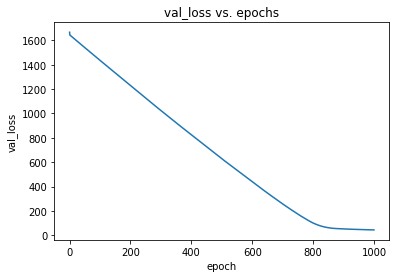

In [34]:
losses = [r['val_loss'] for r in [result] + history1]
plt.plot(losses, '-')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

Predictions

In [35]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [36]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([  1.0000, 219.8157, 228.0000,   7.8000,   0.4550])
Target:  63.5
Prediction: 52.4368896484375


In [37]:
x, target = val_ds[17]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([  1.0000,  11.6314, 212.0000,   7.7000,   0.4490])
Target:  64.30000305175781
Prediction: 52.0979118347168


In [38]:
x, target = val_ds[23]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([  1.0000, 111.2274, 399.0000,  10.4000,   0.4880])
Target:  58.0
Prediction: 61.79174041748047


In [39]:
# final parameters
list(model.parameters())

[Parameter containing:
 tensor([[ 1.0253e+01,  1.2997e-05, -5.2677e-03,  3.8751e+00,  5.5064e+00]],
        requires_grad=True),
 Parameter containing:
 tensor([10.6503], requires_grad=True)]

In [40]:
# save the model to disk
filename = 'linear_regression.pkl'
pickle.dump(model, open(filename, 'wb'))